# Online support vector classification with kernels
Each new datapoint may enter or leave the *support vector set*. That makes the QP evolve over time.


### Problem setup

We consider binary classification with data arriving sequentially:

* At round $t$, receive $(x_t, y_t)$, with $x_t \in \mathbb{R}^d$, $y_t \in \{-1,1\}$.
* Maintain a kernel SVM model with active support vectors $S_t$.
* Solve the dual SVM problem on $S_t$:

$$
\begin{aligned}
\max_{\alpha \in \mathbb{R}^{|S_t|}} \;& \sum_{i=1}^{|S_t|} \alpha_i - \tfrac{1}{2} \sum_{i,j=1}^{|S_t|} \alpha_i \alpha_j y_i y_j K(x_i, x_j) \\
\text{s.t. } & 0 \le \alpha_i \le C,\;\; \sum_{i=1}^{|S_t|} \alpha_i y_i = 0.
\end{aligned}
$$

This is a **quadratic program** with:

* Quadratic objective in $\alpha$.
* Linear equality constraint (label balance).
* Box constraints on $\alpha$.

As new points arrive:

* If the margin condition is violated, add $x_t$ to $S_t$.
* If budget exceeded, remove a support vector (budgeted SVM).
  Thus the dimension of the QP and the constraint set change online.

### Key properties for us

* Each new data point can change the set of decision variables ($\alpha$) and constraints.
* The QP has the same structure but varying size.
* Real-time requirement: in practice, online kernel SVMs need fast repeated QP solves.

In [3]:
import numpy as np
import cvxpy as cp

# Gaussian kernel
def rbf_kernel(X, Y=None, gamma=1.0):
    if Y is None:
        Y = X
    X_norm = np.sum(X**2, axis=1)[:, None]
    Y_norm = np.sum(Y**2, axis=1)[None, :]
    K = np.exp(-gamma * (X_norm + Y_norm - 2 * X @ Y.T))
    return K

def solve_svm_dual(X, y, C=1.0, gamma=1.0):
    n = X.shape[0]
    K = rbf_kernel(X, gamma=gamma)
    # QP variables
    alpha = cp.Variable(n)
    # Dual objective
    obj = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(cp.multiply(y, alpha), K))
    # Constraints
    constraints = [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y)) == 0]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver="OSQP", verbose=False)
    return alpha.value

# Simulated online process
np.random.seed(0)
X = np.random.randn(20, 2)
y = np.random.choice([-1, 1], size=20)

support_set = []
budget = 10
C = 1.0
gamma = 0.5

for t in range(len(y)):
    support_set.append(t)
    if len(support_set) > budget:
        # Simple budget policy: drop oldest
        support_set.pop(0)

    Xs, ys = X[support_set], y[support_set]
    alpha = solve_svm_dual(Xs, ys, C=C, gamma=gamma)
    print(f"t={t}, support size={len(support_set)}, alphas={alpha}") #[:3]

t=0, support size=1, alphas=[6.28716735e-07]
t=1, support size=2, alphas=[1. 1.]
t=2, support size=3, alphas=[1.        0.3744262 0.6255738]
t=3, support size=4, alphas=[1.00000001 1.         1.         0.99999999]
t=4, support size=5, alphas=[1.         0.27590118 0.97545821 1.         0.74864061]
t=5, support size=6, alphas=[1. 1. 1. 1. 1. 1.]
t=6, support size=7, alphas=[0.67986913 1.         1.         1.         1.         1.
 0.32013087]
t=7, support size=8, alphas=[1. 1. 1. 1. 1. 1. 1. 1.]
t=8, support size=9, alphas=[0.45305211 1.         1.         1.         1.         1.
 1.         1.         0.54694789]
t=9, support size=10, alphas=[ 4.48427600e-01  1.00000000e+00  1.00000000e+00 -1.41010239e-23
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  5.88276917e-01  9.63295483e-01]
t=10, support size=10, alphas=[1.00000000e+00 1.00000000e+00 5.04958712e-23 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 8.12422405e-01
 6.99363801e-01 4.88213795e-01]

ValueError: operands could not be broadcast together with shapes (10,) (20,) 

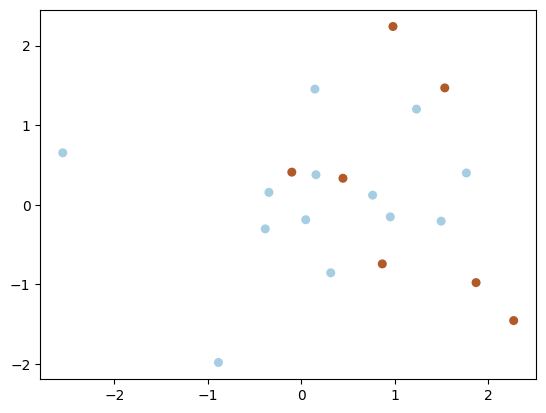

In [5]:
import matplotlib.pyplot as plt

def plot_decision_boundary(X, y, alpha, gamma=1.0):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                         np.linspace(ylim[0], ylim[1], 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    K_grid = rbf_kernel(grid, X, gamma=gamma)
    decision_values = K_grid @ (alpha * y)
    Z = decision_values.reshape(xx.shape)

    ax.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5,
               linestyles='--')
    plt.show()

plot_decision_boundary(X, y, alpha, gamma=gamma)

In [ ]:
## model QP here as graph